In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import itertools
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm, trange
from dataloader import getData, RetinopathyLoader
from torch.utils.data import DataLoader
from models import ResNet
from torchvision import transforms

In [2]:
mean = torch.tensor([0.1857, 0.2602, 0.3749]) 
std = torch.tensor([0.1291, 0.1780, 0.2525])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), # 隨機旋轉圖片
    transforms.Normalize(mean=mean, std=mean),
])

val_transform = transforms.Compose([               
    transforms.Normalize(mean=mean, std=mean),               
])

root = './data'
batch_size = 16
train_set = RetinopathyLoader(root, 'train', transform = train_transform)
val_set = RetinopathyLoader(root, 'test', transform = val_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

> Found 28099 images...
> Found 7025 images...


In [3]:
# version, pretrained, num_epoch
model_settings = [[50, True, 10], [50, False, 10], [18, True, 10], [18, False, 10]]
train_accuracy = [list() for _ in range(4)]
val_accuracy = [list() for _ in range(4)]

for idx, model_setting in enumerate(model_settings):
    version, pretrained, num_epoch = model_setting
    print(f'resnet{version} {"with" if pretrained else "wo"} pretrained training start.')
    
    model = ResNet(version=version, pretrained=pretrained).cuda()
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
    
    best_acc = 0.0
    for epoch in range(num_epoch):
        epoch_start_time = time.time()
        train_acc = 0.0
        train_loss = 0.0
        val_acc = 0.0
        val_loss = 0.0
        train_count = 1e-8
        val_count = 1e-8

        progress = tqdm(total = len(train_loader) + len(val_loader), colour='purple', \
                        bar_format='{desc}{percentage:3.0f}%|{bar}|{n}/{total}[{rate_fmt}{postfix}]')
        model.train()
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            train_pred = model(data[0].type(torch.FloatTensor).cuda())
            batch_loss = loss(train_pred, data[1].cuda())
            batch_loss.backward()
            optimizer.step()

            train_acc += np.sum(np.argmax(train_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
            train_loss += batch_loss.item() * len(train_pred)
            train_count += len(train_pred)

            progress.set_description('[{:03d}/{:03d}] {:2.2f} sec(s) Train Acc: {:3.2f}% Loss: {:3.2f} | Val Acc: {:3.2f}% loss: {:3.2f}]' \
            .format(epoch+1, num_epoch, time.time()-epoch_start_time, \
            train_acc/train_count*100, train_loss/train_count, \
            val_acc/val_count*100, val_loss/val_count))
            progress.update(1)
        train_accuracy[idx].append(train_acc/train_count*100)

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                val_pred = model(data[0].type(torch.FloatTensor).cuda())
                batch_loss = loss(val_pred, data[1].cuda())

                val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
                val_loss += batch_loss.item() * len(val_pred)
                val_count += len(val_pred)

                progress.set_description('[{:03d}/{:03d}] {:2.2f} sec(s) Train Acc: {:3.2f}% Loss: {:3.2f} | Val Acc: {:3.2f}% loss: {:3.2f}]' \
                .format(epoch+1, num_epoch, time.time()-epoch_start_time, \
                 train_acc/train_count*100, train_loss/train_count, \
                val_acc/val_count*100, val_loss/val_count))
                progress.update(1)
            val_accuracy[idx].append(val_acc/val_count*100)
        
        if val_acc/val_count*100 > best_acc:
            best_acc = val_acc/val_count*100
            torch.save(model.state_dict(), f'./model/resnet{version}_{"with" if pretrained else "wo"}_pretrained.pt')
        

resnet50 with pretrained training start.


  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

resnet50 wo pretrained training start.


  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

resnet18 with pretrained training start.


  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

resnet18 wo pretrained training start.


  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

  0%|          |0/2197[?it/s]

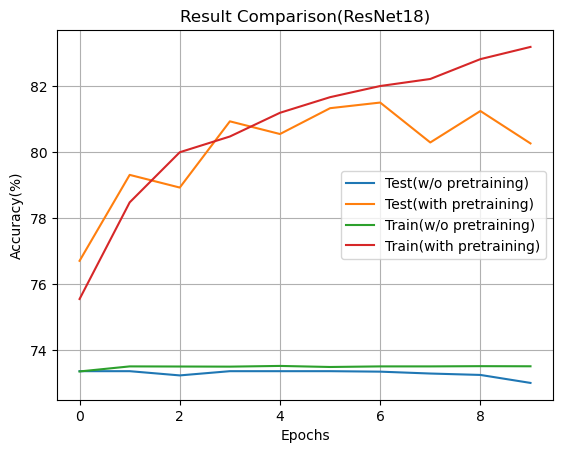

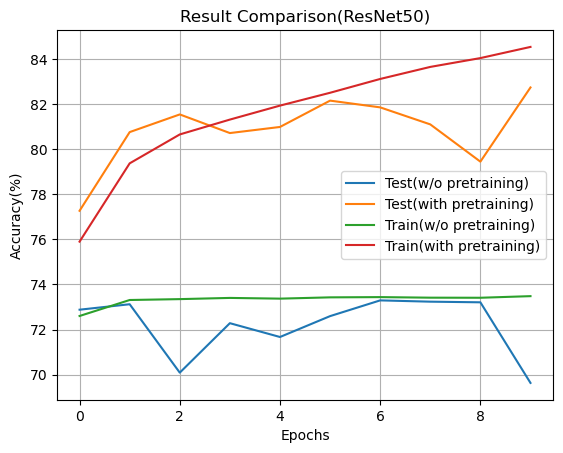

In [30]:
plt.figure()
plt.plot(val_accuracy[3], label='Test(w/o pretraining)')
plt.plot(val_accuracy[2], label='Test(with pretraining)')
plt.plot(train_accuracy[3], label='Train(w/o pretraining)')
plt.plot(train_accuracy[2], label='Train(with pretraining)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.title('Result Comparison(ResNet18)')
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.plot(val_accuracy[1], label='Test(w/o pretraining)')
plt.plot(val_accuracy[0], label='Test(with pretraining)')
plt.plot(train_accuracy[1], label='Train(w/o pretraining)')
plt.plot(train_accuracy[0], label='Train(with pretraining)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.title('Result Comparison(ResNet50)')
plt.grid()
plt.legend()
plt.show()

In [52]:
df = list()
df.append([max(val_accuracy[3]), max(val_accuracy[2])])
df.append([max(val_accuracy[1]), max(val_accuracy[0])])
df = pd.DataFrame(df)
df[0] = df[0].apply(lambda x: str(round(x, 2)) + '%')
df[1] = df[1].apply(lambda x: str(round(x, 2)) + '%')
df.index = ['ResNet18', 'ResNet50']
df.columns = ['w/o pretrained', 'with pretrained']
display(df)

,w/o pretrained,with pretrained
ResNet18,73.35%,81.49%
ResNet50,73.3%,82.73%


In [67]:
model = ResNet(version=50, pretrained=True).cuda()
model.load_state_dict(torch.load('./model/resnet50_with_pretrained.pt'))
model.eval()
loss = nn.CrossEntropyLoss()

progress = tqdm(total = len(val_loader), colour='purple', \
                bar_format='{desc}{percentage:3.0f}%|{bar}|{n}/{total}[{rate_fmt}{postfix}]')

val_acc = 0.0
val_count = 1e-8
epoch_start_time = time.time()
y_true, y_pred = list(), list()
with torch.no_grad():
    for i, data in enumerate(val_loader):
        val_pred = model(data[0].type(torch.FloatTensor).cuda())
        batch_loss = loss(val_pred, data[1].type(torch.LongTensor).cuda())

        val_acc += np.sum(np.argmax(val_pred.cpu().data.numpy(), axis=1) == data[1].numpy())
        val_count += len(val_pred)
        y_true += list(data[1].numpy())
        y_pred += list(np.argmax(val_pred.cpu().data.numpy(), axis=1))
        
        progress.set_description('{:2.2f} sec(s) Val Acc: {:3.2f}% loss: {:3.2f}]' \
        .format(time.time()-epoch_start_time, \
        val_acc/val_count*100, val_loss/val_count))
        progress.update(1)
    print(f'accuracy: {val_acc/val_set.__len__()*100}')

  0%|          |0/440[?it/s]

accuracy: 82.73309608540926


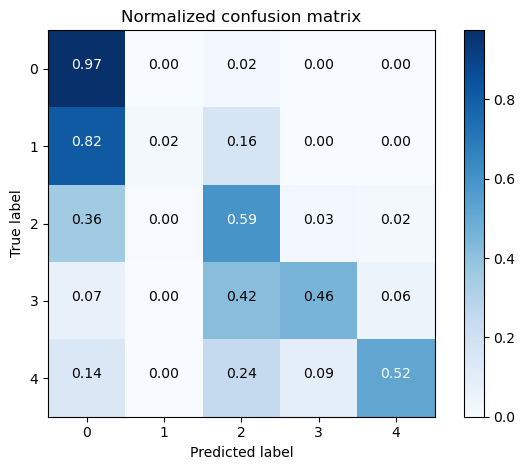

In [84]:
plt.figure()
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()